## Case study: étude de l'offre et du positionnement de Freeglisse



**_Contexte_**

Olist aimerait désormais **augmenter son offre sur le segment du sport**, en incitant des marketplaces d'articles de sport à rejoindre la plateforme. Pour affiner sa stratégie vis-à-vis de ce type de vendeurs, Olist a besoin **d'analyser leur offre et leur positionnement**, pour mieux connaitre le marché sur lequel ils évoluent.

En particulier, les Sales d'Olist s'intéressent à **FreeGlisse**, une plateforme de vente en ligne de matériel de ski d'occasion. Leur ojectif est d'emmagasiner le plus d’informations possibles à partir de ce que FreeGlisse affiche sur son site web.
<br><br>

**_Instructions_**

Olist voudrait se concentrer dans un premier temps sur le segment des **skis**. Les informations à étudier incluent : **le nombre d'annonces sur les skis**, les **prix** pratiqués, la **répartition de l’offre entre les différentes sous-catégories**, eventuellement la **profondeur des stocks** (= le nombre de produits disponibles, ou le nombre de tailles disponibles par produit), et tout ce que vous pensez qui serait **intéressant pour analyser le positionnement marché de FreeGlisse**.

Ces informations seraient d’autant plus intéressantes si elles étaient étudiées **par type de ski** (indiqué dans la Fiche Technique de chaque ski). N'hésitez pas à effectuer les regroupements qui vous semblent pertinents, à faire des analyses quantitatives et qualitatives, en utilisant **pandas** et en faisant de beaux **graphiques**. Pour les graphiques, vous utiliserez **Google Data Studio**.

Côté technique, 2 compétences pourront être mises en oeuvre: le **crawling** entre les différentes pages du site, pour observer l’ensemble des offres de skis d’occasion (ici, pas besoin de selenium - des techniques plus simples seront possibles), et le **scraping des pages individuelles**, avec différentes infos à aller chercher.

Pour finir, l'objectif de ce cas est aussi de tirer de ces analyses des **insights business**, en particulier des **conclusions sur le positionnement commercial de FreeGlisse et les spécificités qu'il pourrait apporter à Olist**.
<br><br>

**_Présentation_**

En groupe, vous devrez **analyser les informations issues du scraping**, puis en fin de projet **présenter en environ 5 minutes** votre analyse à des Product Managers d'Olist (jurys de Databirdies), sous forme de **dashboard Data Studio**. L'essentiel est que la présentation soit **visuelle et intelligible par des stakeholders non-tech**.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import requests
from bs4 import BeautifulSoup

def get_all_product_urls(base_url):
    all_product_urls = []
    current_page = 1
    while True:
        # Construire l'URL de la page actuelle en ajoutant le paramètre de pagination
        url = f"{base_url}?page={current_page}"
        response = requests.get(url)
        if response.status_code != 200:
            break 

        soup = BeautifulSoup(response.content, 'html.parser')
        products = soup.find_all('div', class_='product')

        # Trouver l'URL de chaque produit et l'ajouter à la liste
        page_product_urls = [p.find('a')['href'] for p in products if p.find('a')]
        if not page_product_urls:
            break  # Arrêter si aucune URL de produit n'est trouvée sur la page

        all_product_urls.extend(page_product_urls)

        # Vérifier s'il y a une page suivante
        next_button = soup.find('a', rel='next')
        if not next_button or 'disabled' in next_button.get('class', []):
            break  # Arrêter si il n'y a pas de bouton 'suivant' ou s'il est désactivé
        
        current_page += 1  # Incrémenter le numéro de page
        
    return all_product_urls


# URL de la première page des produits
base_url = 'https://freeglisse.com/fr/12-ski-occasion'
product_urls = get_all_product_urls(base_url)



In [3]:
product_urls

['https://freeglisse.com/fr/ski-occasion-adulte-freeride-et-freestyle/18916-431280-ski-occasion-rossignol-sender-104-ti-2023-fixations.html#/3-etat_du_materiel-qualite_a/906-taille_skis-164_cm',
 'https://freeglisse.com/fr/ski-occasion-adulte-freeride-et-freestyle/18915-431270-ski-occasion-rossignol-sender-94-ti-2023-fixations.html#/3-etat_du_materiel-qualite_a/898-taille_skis-156_cm',
 'https://freeglisse.com/fr/ski-de-fond-occasion-alternatif-norme-sns/18974-434106-ski-de-fond-occasion-rossignol-lts-junior-fixation-sns-profil.html#/892-taille_skis-150_cm/1768-etat_du_materiel-qualite_c',
 'https://freeglisse.com/fr/ski-de-fond-occasion-alternatif-norme-sns/15468-165924-ski-de-fond-occasion-toutes-marques-fixation-sns-profil.html#/882-taille_skis-140_cm/1768-etat_du_materiel-qualite_c',
 'https://freeglisse.com/fr/ski-occasion-femme-loisir/18890-430528-ski-occasion-rossignol-nova-6-fixations.html#/3-etat_du_materiel-qualite_a/891-taille_skis-149_cm',
 'https://freeglisse.com/fr/ski-oc

In [4]:
len(product_urls)

180

In [5]:

def scrape_product_reviews(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = []
    reviews_container = soup.find_all('div', class_='netreviews_review_part')
    for review in reviews_container:
        comment = review.find('p', class_='netreviews_customer_review').text.strip()
        reviews.append(comment)
    return reviews

In [6]:
def scrape_product_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extraire le lien canonique
    canonical_link = soup.find('link', rel='canonical')['href']

    # Extraire la référence
    reference = soup.find('label', class_='label title-cate').find_next('span').text

    # Extraire le titre
    title = soup.find('h1', class_='h1 product-detail-name').text
    
    # Extraire la marque depuis l'attribut 'alt' de l'img
    brand_tag = soup.find('img', class_='img img-thumbnail manufacturer-logo')
    brand = brand_tag['alt'] if brand_tag else None

    # Extraire le prix hors taxes
    pretax_price_meta = soup.find('meta', property='product:pretax_price:amount')
    pretax_price = pretax_price_meta['content'] if pretax_price_meta else None

    # Extraire le prix habituel et le prix actuel
    regular_price_tag = soup.find('span', class_='regular-price')
    current_price = soup.find('span', class_='current-price-value').text.strip().replace('\xa0', '')

    # Extraire l'information de disponibilité
    available = soup.find('span', id='availability_message').text

    # Extraire les qualités
    qualities = [span.text for span in soup.find_all('span', class_='radio-label') 
                if not span.find_previous_sibling('input', type='radio').has_attr('disabled')]

    # Extraire le poids du produit
    product_weight_meta = soup.find('meta', property='product:weight:value')
    product_weight = product_weight_meta['content'] if product_weight_meta else None

    # Extraire les avis des produits
    product_reviews = scrape_product_reviews(url)
    
    # Extraire le nombre donné par étoiles
    reviews_count_1_star = soup.find('span', class_='netreviews_rate_total1').text.strip() if soup.find('span', class_='netreviews_rate_total1') else '0'
    reviews_count_2_stars = soup.find('span', class_='netreviews_rate_total2').text.strip() if soup.find('span', class_='netreviews_rate_total2') else '0'
    reviews_count_3_stars = soup.find('span', class_='netreviews_rate_total3').text.strip() if soup.find('span', class_='netreviews_rate_total3') else '0'
    reviews_count_4_stars = soup.find('span', class_='netreviews_rate_total4').text.strip() if soup.find('span', class_='netreviews_rate_total4') else '0'
    reviews_count_5_stars = soup.find('span', class_='netreviews_rate_total5').text.strip() if soup.find('span', class_='netreviews_rate_total5') else '0'

    # Extraire la note générale
    note_generale = None
    note_generale_tag = soup.find('p', class_='netreviews_note_generale')
    if note_generale_tag:
        note_generale_text = note_generale_tag.text.strip()
        if note_generale_text:
            note_generale = note_generale_text.split()[0] + "/5"

    # Extraire le nombre d'avis
    nombre_avis = None
    review_count_tag = soup.find('span', id='reviewCount')
    if review_count_tag:
        review_count_text = review_count_tag.text.strip()
        if re.match(r'^\d+$', review_count_text):
            nombre_avis = int(review_count_text)

    # Extraire les détails du produit
    product_details = {}
    details = soup.find_all(['dt', 'dd'])
    for i in range(0, len(details), 2):
        if details[i].get('class', [''])[0] == 'name' and details[i + 1].get('class', [''])[0] == 'value':
            product_details[details[i].text.strip()] = details[i + 1].text.strip()

    # Extraire l'URL de la première image du produit
    image_urls_tag = soup.find('img', class_='img img-thumb')
    image_urls = image_urls_tag['src'] if image_urls_tag else None


    # Construire et retourner un dictionnaire des informations du produit
    return {
        'title': title,
        'brand': brand,
        'regular_price': regular_price_tag,
        'current_price': current_price,
        'details': product_details,
        'available': available,
        'reference': reference,
        'qualities': qualities,
        'link': canonical_link,
        'weight': product_weight,
        'general_rate': note_generale,
        'nb_ratings': nombre_avis,
        'reviews': product_reviews,
        'image_urls': image_urls,
        'pretax_price': pretax_price,
        'reviews_count_1_star': reviews_count_1_star,
        'reviews_count_2_stars': reviews_count_2_stars,
        'reviews_count_3_stars': reviews_count_3_stars,
        'reviews_count_4_stars': reviews_count_4_stars,
        'reviews_count_5_stars': reviews_count_5_stars,
    }


In [8]:
# URL de la première page des produits
base_url = 'https://freeglisse.com/fr/12-ski-occasion'
product_urls = get_all_product_urls(base_url)

# Liste pour stocker les détails de tous les produits
all_product_details = []

# Parcourir chaque URL de produit et récupérer les détails
for url in product_urls:
    details = scrape_product_page(url)
    all_product_details.append(details)

all_product_details

[{'title': 'Ski occasion Rossignol Sender 104 Ti 2023  + Fixations',
  'brand': 'Rossignol',
  'regular_price': <span class="regular-price">419,00 €</span>,
  'current_price': '335,20€',
  'details': {'Type': 'Freeride',
   'Utilisateur': 'Mixte',
   'Niveau': 'Performant',
   'Coloris': 'Gris',
   'Utilisateur - Configurateur': 'Freerideur adulte',
   'Economie de CO2 pour la planète (en kg)': '3.6',
   'Type de produit': 'Ski occasion freeride'},
  'available': 'Disponible',
  'reference': '18916_m27',
  'qualities': ['Qualité A',
   '164 cm',
   '172 cm',
   '178 cm',
   '186 cm',
   'Qualité A',
   '164 cm',
   '172 cm',
   '178 cm',
   '186 cm'],
  'link': 'https://freeglisse.com/fr/ski-occasion-adulte-freeride-et-freestyle/18916-ski-occasion-rossignol-sender-104-ti-2023-fixations.html',
  'weight': '6.000000',
  'general_rate': None,
  'nb_ratings': None,
  'reviews': [],
  'image_urls': 'https://freeglisse.com/70892-small_default/ski-occasion-rossignol-sender-104-ti-2023-fixatio

In [9]:
df = pd.DataFrame(all_product_details)
df.head()

,title,brand,regular_price,current_price,details,available,reference,qualities,link,weight,general_rate,nb_ratings,reviews,image_urls,pretax_price,reviews_count_1_star,reviews_count_2_stars,reviews_count_3_stars,reviews_count_4_stars,reviews_count_5_stars
0,Ski occasion Rossignol Sender 104 Ti 2023 + F...,Rossignol,"[419,00 €]","335,20€","{'Type': 'Freeride', 'Utilisateur': 'Mixte', '...",Disponible,18916_m27,"[Qualité A, 164 cm, 172 cm, 178 cm, 186 cm, Qu...",https://freeglisse.com/fr/ski-occasion-adulte-...,6.000000,None,NaN,[],https://freeglisse.com/70892-small_default/ski...,279.333334,0,0,0,0,0
1,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,Rossignol,"[359,00 €]","287,20€","{'Type': 'Freeride', 'Utilisateur': 'Mixte', '...",Disponible,18915_i26,"[Qualité A, 156 cm, 164 cm, 172 cm, Qualité A,...",https://freeglisse.com/fr/ski-occasion-adulte-...,6.000000,4/5,1.0,[good cuality],https://freeglisse.com/70897-small_default/ski...,239.333334,0,0,0,1,0
2,Ski de fond occasion Rossignol LTS Junior + fi...,Rossignol,None,"19,00€","{'Type': 'Alternatif', 'Utilisateur': 'Junior'...",Disponible,18974_mz_l18_violet,"[Qualité C, 150 cm, 160 cm, 170 cm, Qualité C,...",https://freeglisse.com/fr/ski-de-fond-occasion...,4.000000,None,NaN,[],None,15.833333,0,0,0,0,0
3,Ski de fond occasion Toutes marques + fixation...,Toutes marques,None,"15,00€","{'Type': 'Alternatif', 'Utilisateur': 'Mixte',...",Disponible,15468_mz_l20,"[Qualité C, 140 cm, 150 cm, 160 cm, 170 cm, Qu...",https://freeglisse.com/fr/ski-de-fond-occasion...,4.000000,4.8/5,10.0,[Je n'ai pas encore pu les tester car pas de c...,https://freeglisse.com/43792-small_default/ski...,12.5,0,0,0,2,8
4,Ski occasion Rossignol Nova 6 + fixations,Rossignol,None,"169,00€","{'Type': 'Piste', 'Utilisateur': 'Femme', 'Niv...",Disponible,18890_l20,"[Qualité A, Qualité B, Qualité C, 149 cm, Qual...",https://freeglisse.com/fr/ski-occasion-femme-l...,6.000000,3.2/5,5.0,"[Etat du produit conforme à mes attentes!, Gew...",https://freeglisse.com/70606-small_default/ski...,140.833333,2,0,0,1,2


In [10]:
details = pd.json_normalize(df['details'])

In [11]:
df = df[['link', 'reference', 'brand', 'title', 'regular_price','current_price', 'available', 'qualities', 'weight', 'general_rate', 'nb_ratings', 'reviews', 'image_urls', 'pretax_price', 'reviews_count_1_star', 'reviews_count_2_stars', 'reviews_count_3_stars', 'reviews_count_4_stars', 'reviews_count_5_stars']]

In [12]:
df = pd.concat([df, details], axis=1)

In [13]:
df = df.rename(columns={'current_price': 'price'})

In [14]:
import pandas as pd
import re

def extract_qualities_and_sizes(qualities_list):
    quality_pattern = re.compile(r'Qualité [A-Z]')
    size_pattern = re.compile(r'\d+ cm')

    available_qualities = [q for q in qualities_list if quality_pattern.match(q)]
    sizes = [s for s in qualities_list if size_pattern.match(s)]

    # Élimination des doublons pour les qualités
    available_qualities = list(set(available_qualities))
    sizes = list(set(sizes))
    
    return available_qualities, sizes

# Application de la fonction à chaque ligne du dataframe
df['available_qualities'], df['sizes'] = zip(*df['qualities'].apply(extract_qualities_and_sizes))

# Affichage pour vérification
df['available_qualities'].head(), df['sizes'].head()


(0                          [Qualité A]
 1                          [Qualité A]
 2                          [Qualité C]
 3                          [Qualité C]
 4    [Qualité A, Qualité C, Qualité B]
 Name: available_qualities, dtype: object,
 0    [178 cm, 172 cm, 186 cm, 164 cm]
 1            [156 cm, 172 cm, 164 cm]
 2            [170 cm, 160 cm, 150 cm]
 3    [170 cm, 160 cm, 140 cm, 150 cm]
 4                            [149 cm]
 Name: sizes, dtype: object)

In [15]:
df = df.drop(columns='qualities')
df.head()

,link,reference,brand,title,regular_price,price,available,weight,general_rate,nb_ratings,...,reviews_count_5_stars,Type,Utilisateur,Niveau,Coloris,Utilisateur - Configurateur,Economie de CO2 pour la planète (en kg),Type de produit,available_qualities,sizes
0,https://freeglisse.com/fr/ski-occasion-adulte-...,18916_m27,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,"[419,00 €]","335,20€",Disponible,6.000000,None,NaN,...,0,Freeride,Mixte,Performant,Gris,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[178 cm, 172 cm, 186 cm, 164 cm]"
1,https://freeglisse.com/fr/ski-occasion-adulte-...,18915_i26,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,"[359,00 €]","287,20€",Disponible,6.000000,4/5,1.0,...,0,Freeride,Mixte,Performant,Noir,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[156 cm, 172 cm, 164 cm]"
2,https://freeglisse.com/fr/ski-de-fond-occasion...,18974_mz_l18_violet,Rossignol,Ski de fond occasion Rossignol LTS Junior + fi...,None,"19,00€",Disponible,4.000000,None,NaN,...,0,Alternatif,Junior,Loisir,Violet,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 150 cm]"
3,https://freeglisse.com/fr/ski-de-fond-occasion...,15468_mz_l20,Toutes marques,Ski de fond occasion Toutes marques + fixation...,None,"15,00€",Disponible,4.000000,4.8/5,10.0,...,8,Alternatif,Mixte,Loisir,Blanc,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 140 cm, 150 cm]"
4,https://freeglisse.com/fr/ski-occasion-femme-l...,18890_l20,Rossignol,Ski occasion Rossignol Nova 6 + fixations,None,"169,00€",Disponible,6.000000,3.2/5,5.0,...,2,Piste,Femme,Loisir,Violet,une femme,3.6,Ski occasion femme loisir,"[Qualité A, Qualité C, Qualité B]",[149 cm]


In [16]:
df['price'] = df['price'].str.replace(',', '.').str.replace('€', '').astype(float)


In [17]:
df['regular_price'] = df['regular_price'].astype(str)

In [18]:
df.dtypes

link                                        object
reference                                   object
brand                                       object
title                                       object
regular_price                               object
price                                      float64
available                                   object
weight                                      object
general_rate                                object
nb_ratings                                 float64
reviews                                     object
image_urls                                  object
pretax_price                                object
reviews_count_1_star                        object
reviews_count_2_stars                       object
reviews_count_3_stars                       object
reviews_count_4_stars                       object
reviews_count_5_stars                       object
Type                                        object
Utilisateur                    

In [19]:
df['regular_price'] = (
    df['regular_price']
    .str.extract(r'(\d+[\.,]?\d*)')[0]  # Extrait les nombres avec un point ou une virgule comme séparateur décimal.
    .str.replace(',', '.')  # Remplace la virgule par un point décimal.
    .astype(float)  # Convertit en float.
)


In [20]:
df['regular_price'] = df['regular_price'].replace(5, np.nan)

In [21]:
df['price'].describe()

count    180.000000
mean     134.342778
std      102.643818
min        9.000000
25%       55.000000
50%      104.000000
75%      191.500000
max      469.000000
Name: price, dtype: float64

In [22]:
df.head()

,link,reference,brand,title,regular_price,price,available,weight,general_rate,nb_ratings,...,reviews_count_5_stars,Type,Utilisateur,Niveau,Coloris,Utilisateur - Configurateur,Economie de CO2 pour la planète (en kg),Type de produit,available_qualities,sizes
0,https://freeglisse.com/fr/ski-occasion-adulte-...,18916_m27,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,419.0,335.2,Disponible,6.000000,None,NaN,...,0,Freeride,Mixte,Performant,Gris,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[178 cm, 172 cm, 186 cm, 164 cm]"
1,https://freeglisse.com/fr/ski-occasion-adulte-...,18915_i26,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,359.0,287.2,Disponible,6.000000,4/5,1.0,...,0,Freeride,Mixte,Performant,Noir,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[156 cm, 172 cm, 164 cm]"
2,https://freeglisse.com/fr/ski-de-fond-occasion...,18974_mz_l18_violet,Rossignol,Ski de fond occasion Rossignol LTS Junior + fi...,NaN,19.0,Disponible,4.000000,None,NaN,...,0,Alternatif,Junior,Loisir,Violet,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 150 cm]"
3,https://freeglisse.com/fr/ski-de-fond-occasion...,15468_mz_l20,Toutes marques,Ski de fond occasion Toutes marques + fixation...,NaN,15.0,Disponible,4.000000,4.8/5,10.0,...,8,Alternatif,Mixte,Loisir,Blanc,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 140 cm, 150 cm]"
4,https://freeglisse.com/fr/ski-occasion-femme-l...,18890_l20,Rossignol,Ski occasion Rossignol Nova 6 + fixations,NaN,169.0,Disponible,6.000000,3.2/5,5.0,...,2,Piste,Femme,Loisir,Violet,une femme,3.6,Ski occasion femme loisir,"[Qualité A, Qualité C, Qualité B]",[149 cm]


In [23]:
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['weight'] = df['weight'].round()

In [24]:
df = df.rename(columns={'Type': 'type', 
                        'Utilisateur': 'user', 
                        'Niveau': 'level', 
                        'Utilisateur - Configurateur': 'user_config', 
                        'Economie de CO2 pour la planète (en kg)': 'eco_co2',
                        'Type de produit': 'product_type',
                        'available_qualities': 'qualities',
                        'Coloris': 'color'
                        })

In [25]:
df.head()

,link,reference,brand,title,regular_price,price,available,weight,general_rate,nb_ratings,...,reviews_count_5_stars,type,user,level,color,user_config,eco_co2,product_type,qualities,sizes
0,https://freeglisse.com/fr/ski-occasion-adulte-...,18916_m27,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,419.0,335.2,Disponible,6.0,None,NaN,...,0,Freeride,Mixte,Performant,Gris,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[178 cm, 172 cm, 186 cm, 164 cm]"
1,https://freeglisse.com/fr/ski-occasion-adulte-...,18915_i26,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,359.0,287.2,Disponible,6.0,4/5,1.0,...,0,Freeride,Mixte,Performant,Noir,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[156 cm, 172 cm, 164 cm]"
2,https://freeglisse.com/fr/ski-de-fond-occasion...,18974_mz_l18_violet,Rossignol,Ski de fond occasion Rossignol LTS Junior + fi...,NaN,19.0,Disponible,4.0,None,NaN,...,0,Alternatif,Junior,Loisir,Violet,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 150 cm]"
3,https://freeglisse.com/fr/ski-de-fond-occasion...,15468_mz_l20,Toutes marques,Ski de fond occasion Toutes marques + fixation...,NaN,15.0,Disponible,4.0,4.8/5,10.0,...,8,Alternatif,Mixte,Loisir,Blanc,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 140 cm, 150 cm]"
4,https://freeglisse.com/fr/ski-occasion-femme-l...,18890_l20,Rossignol,Ski occasion Rossignol Nova 6 + fixations,NaN,169.0,Disponible,6.0,3.2/5,5.0,...,2,Piste,Femme,Loisir,Violet,une femme,3.6,Ski occasion femme loisir,"[Qualité A, Qualité C, Qualité B]",[149 cm]


In [26]:
average_price_by_type = df.groupby("type")["price"].mean().sort_values(ascending=False)
average_price_by_type

type
Ski de randonnée    469.000000
Freeride            253.706667
All mountain        181.018919
Racing              149.000000
Polyvalent          121.727273
Piste               105.822727
Freestyle            97.500000
Skating              65.000000
Alternatif           30.714286
Name: price, dtype: float64

<Axes: ylabel='type'>

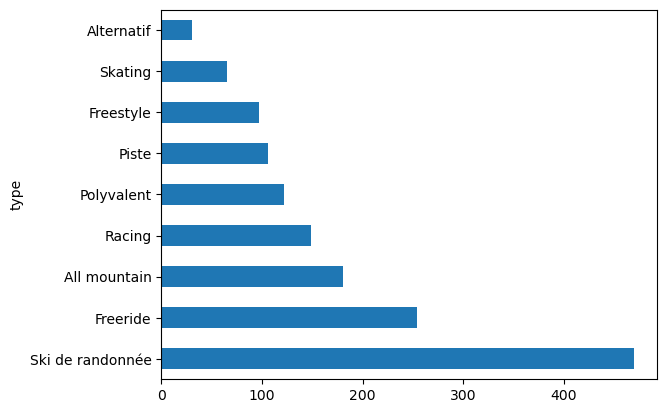

In [27]:
average_price_by_type.plot(kind='barh', x='average_price_by_type')

In [28]:
average_price_by_level = df.groupby("level")["price"].mean().sort_values(ascending=False)

<Axes: ylabel='level'>

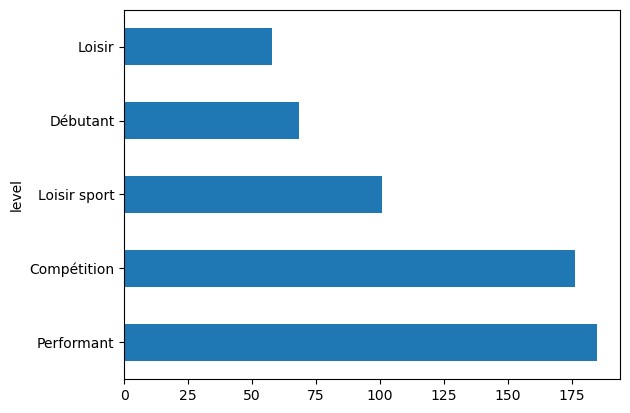

In [29]:
average_price_by_level.plot(kind='barh', x='average_price_by_type')

In [30]:
nb_items_by_category = df.groupby("type")["title"].count().sort_values(ascending=False)
nb_items_by_category.index

Index(['Piste', 'All mountain', 'Freeride', 'Freestyle', 'Polyvalent',
       'Alternatif', 'Racing', 'Skating', 'Ski de randonnée'],
      dtype='object', name='type')

<Axes: ylabel='type'>

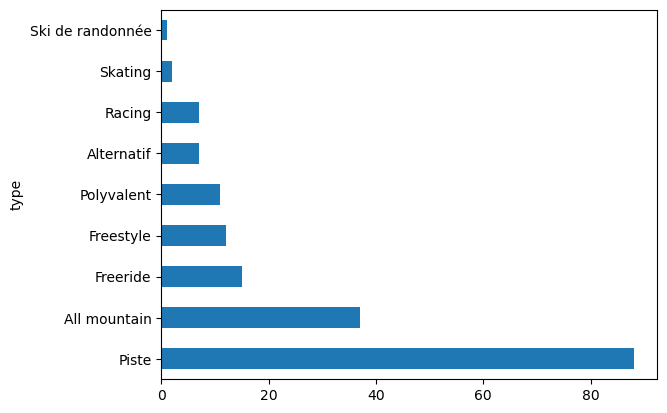

In [31]:
nb_items_by_category.plot(kind='barh', x='average_price_by_type')

In [32]:
nb_items_by_level = df['level'].value_counts()

<Axes: ylabel='level'>

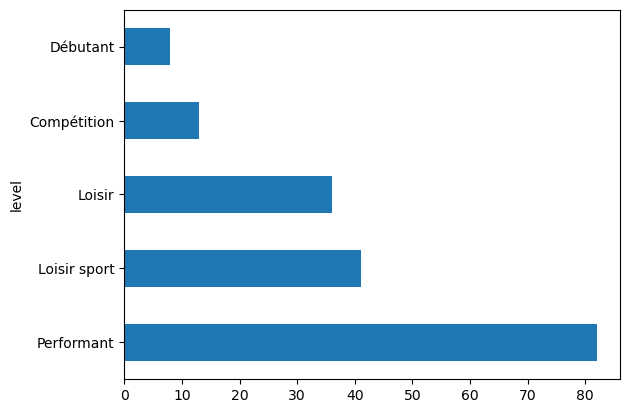

In [33]:
nb_items_by_level.plot(kind='barh', x='average_price_by_type')

In [34]:
df.head()

,link,reference,brand,title,regular_price,price,available,weight,general_rate,nb_ratings,...,reviews_count_5_stars,type,user,level,color,user_config,eco_co2,product_type,qualities,sizes
0,https://freeglisse.com/fr/ski-occasion-adulte-...,18916_m27,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,419.0,335.2,Disponible,6.0,None,NaN,...,0,Freeride,Mixte,Performant,Gris,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[178 cm, 172 cm, 186 cm, 164 cm]"
1,https://freeglisse.com/fr/ski-occasion-adulte-...,18915_i26,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,359.0,287.2,Disponible,6.0,4/5,1.0,...,0,Freeride,Mixte,Performant,Noir,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[156 cm, 172 cm, 164 cm]"
2,https://freeglisse.com/fr/ski-de-fond-occasion...,18974_mz_l18_violet,Rossignol,Ski de fond occasion Rossignol LTS Junior + fi...,NaN,19.0,Disponible,4.0,None,NaN,...,0,Alternatif,Junior,Loisir,Violet,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 150 cm]"
3,https://freeglisse.com/fr/ski-de-fond-occasion...,15468_mz_l20,Toutes marques,Ski de fond occasion Toutes marques + fixation...,NaN,15.0,Disponible,4.0,4.8/5,10.0,...,8,Alternatif,Mixte,Loisir,Blanc,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 140 cm, 150 cm]"
4,https://freeglisse.com/fr/ski-occasion-femme-l...,18890_l20,Rossignol,Ski occasion Rossignol Nova 6 + fixations,NaN,169.0,Disponible,6.0,3.2/5,5.0,...,2,Piste,Femme,Loisir,Violet,une femme,3.6,Ski occasion femme loisir,"[Qualité A, Qualité C, Qualité B]",[149 cm]


In [35]:
df['regular_price'].isna().value_counts()

regular_price
True     170
False     10
Name: count, dtype: int64

In [36]:
type_distribution_by_gender = df.groupby(["user", "type"]).size().unstack(fill_value=0)

type_distribution_by_gender

type,All mountain,Alternatif,Freeride,Freestyle,Piste,Polyvalent,Racing,Skating,Ski de randonnée
user,,,,,,,,,
Femme,8,0,3,0,8,0,0,0,0
Fille,1,0,0,0,3,0,0,0,0
Homme,0,0,0,0,1,0,0,0,0
Junior,3,2,0,2,28,0,2,2,0
Mixte,25,5,12,10,48,11,5,0,1


In [41]:
df.columns

Index(['link', 'reference', 'brand', 'title', 'regular_price', 'price',
       'available', 'weight', 'general_rate', 'nb_ratings', 'reviews',
       'image_urls', 'pretax_price', 'reviews_count_1_star',
       'reviews_count_2_stars', 'reviews_count_3_stars',
       'reviews_count_4_stars', 'reviews_count_5_stars', 'type', 'user',
       'level', 'color', 'user_config', 'eco_co2', 'product_type', 'qualities',
       'sizes'],
      dtype='object')

In [43]:
df['reference'] = df['reference'].str.slice(0, 5)

In [44]:
df.head()

,link,reference,brand,title,regular_price,price,available,weight,general_rate,nb_ratings,...,reviews_count_5_stars,type,user,level,color,user_config,eco_co2,product_type,qualities,sizes
0,https://freeglisse.com/fr/ski-occasion-adulte-...,18916,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,419.0,335.2,Disponible,6.0,None,NaN,...,0,Freeride,Mixte,Performant,Gris,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[178 cm, 172 cm, 186 cm, 164 cm]"
1,https://freeglisse.com/fr/ski-occasion-adulte-...,18915,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,359.0,287.2,Disponible,6.0,4/5,1.0,...,0,Freeride,Mixte,Performant,Noir,Freerideur adulte,3.6,Ski occasion freeride,[Qualité A],"[156 cm, 172 cm, 164 cm]"
2,https://freeglisse.com/fr/ski-de-fond-occasion...,18974,Rossignol,Ski de fond occasion Rossignol LTS Junior + fi...,NaN,19.0,Disponible,4.0,None,NaN,...,0,Alternatif,Junior,Loisir,Violet,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 150 cm]"
3,https://freeglisse.com/fr/ski-de-fond-occasion...,15468,Toutes marques,Ski de fond occasion Toutes marques + fixation...,NaN,15.0,Disponible,4.0,4.8/5,10.0,...,8,Alternatif,Mixte,Loisir,Blanc,NaN,3.6,Ski de fond occasion alternatif norme SNS,[Qualité C],"[170 cm, 160 cm, 140 cm, 150 cm]"
4,https://freeglisse.com/fr/ski-occasion-femme-l...,18890,Rossignol,Ski occasion Rossignol Nova 6 + fixations,NaN,169.0,Disponible,6.0,3.2/5,5.0,...,2,Piste,Femme,Loisir,Violet,une femme,3.6,Ski occasion femme loisir,"[Qualité A, Qualité C, Qualité B]",[149 cm]


In [45]:
df.columns

Index(['link', 'reference', 'brand', 'title', 'regular_price', 'price',
       'available', 'weight', 'general_rate', 'nb_ratings', 'reviews',
       'image_urls', 'pretax_price', 'reviews_count_1_star',
       'reviews_count_2_stars', 'reviews_count_3_stars',
       'reviews_count_4_stars', 'reviews_count_5_stars', 'type', 'user',
       'level', 'color', 'user_config', 'eco_co2', 'product_type', 'qualities',
       'sizes'],
      dtype='object')

In [46]:
columns_order = ['link', 'reference', 'brand', 'title', 'available', 'pretax_price', 'regular_price', 'price', 'type', 'user', 'level', 'color',
        'user_config', 'eco_co2', 'product_type', 'qualities', 'sizes', 'weight', 'general_rate', 'nb_ratings', 'reviews',
        'reviews_count_1_star', 'reviews_count_2_stars', 'reviews_count_3_stars', 'reviews_count_4_stars', 'reviews_count_5_stars', 'image_urls']
df = df[columns_order]

In [47]:
df['pretax_price'] = round(df['pretax_price'].astype(float), 2)

In [48]:
df['reviews_count_1_star'] = df['reviews_count_1_star'].astype(int)
df['reviews_count_2_stars'] = df['reviews_count_2_stars'].astype(int)
df['reviews_count_3_stars'] = df['reviews_count_3_stars'].astype(int)
df['reviews_count_4_stars'] = df['reviews_count_4_stars'].astype(int)
df['reviews_count_5_stars'] = df['reviews_count_5_stars'].astype(int)

In [49]:
columns_stocks = ['link', 'qualities', 'sizes']
df_stock = df[columns_stocks]

In [50]:
df_stock

,link,qualities,sizes
0,https://freeglisse.com/fr/ski-occasion-adulte-...,[Qualité A],"[178 cm, 172 cm, 186 cm, 164 cm]"
1,https://freeglisse.com/fr/ski-occasion-adulte-...,[Qualité A],"[156 cm, 172 cm, 164 cm]"
2,https://freeglisse.com/fr/ski-de-fond-occasion...,[Qualité C],"[170 cm, 160 cm, 150 cm]"
3,https://freeglisse.com/fr/ski-de-fond-occasion...,[Qualité C],"[170 cm, 160 cm, 140 cm, 150 cm]"
4,https://freeglisse.com/fr/ski-occasion-femme-l...,"[Qualité A, Qualité C, Qualité B]",[149 cm]
...,...,...,...
175,https://freeglisse.com/fr/ski-occasion-adulte-...,[],[]
176,https://freeglisse.com/fr/ski-occasion-freerid...,[],[]
177,https://freeglisse.com/fr/ski-occasion-junior-...,[],[]
178,https://freeglisse.com/fr/ski-occasion-junior-...,[],[]


In [51]:
df_filtered = df_stock[df_stock['qualities'].apply(lambda x: len(x) > 0) & df_stock['sizes'].apply(lambda x: len(x) > 0)]

In [52]:
df_filtered.to_csv('df_filtered.csv')

In [53]:
df.dtypes

link                      object
reference                 object
brand                     object
title                     object
available                 object
pretax_price             float64
regular_price            float64
price                    float64
type                      object
user                      object
level                     object
color                     object
user_config               object
eco_co2                   object
product_type              object
qualities                 object
sizes                     object
weight                   float64
general_rate              object
nb_ratings               float64
reviews                   object
reviews_count_1_star       int64
reviews_count_2_stars      int64
reviews_count_3_stars      int64
reviews_count_4_stars      int64
reviews_count_5_stars      int64
image_urls                object
dtype: object

In [54]:
df.head(2)

,link,reference,brand,title,available,pretax_price,regular_price,price,type,user,...,weight,general_rate,nb_ratings,reviews,reviews_count_1_star,reviews_count_2_stars,reviews_count_3_stars,reviews_count_4_stars,reviews_count_5_stars,image_urls
0,https://freeglisse.com/fr/ski-occasion-adulte-...,18916,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,Disponible,279.33,419.0,335.2,Freeride,Mixte,...,6.0,None,NaN,[],0,0,0,0,0,https://freeglisse.com/70892-small_default/ski...
1,https://freeglisse.com/fr/ski-occasion-adulte-...,18915,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,Disponible,239.33,359.0,287.2,Freeride,Mixte,...,6.0,4/5,1.0,[good cuality],0,0,0,1,0,https://freeglisse.com/70897-small_default/ski...


In [57]:
df['link'][0]

'https://freeglisse.com/fr/ski-occasion-adulte-freeride-et-freestyle/18916-ski-occasion-rossignol-sender-104-ti-2023-fixations.html'

In [58]:
df.columns

Index(['link', 'reference', 'brand', 'title', 'available', 'pretax_price',
       'regular_price', 'price', 'type', 'user', 'level', 'color',
       'user_config', 'eco_co2', 'product_type', 'qualities', 'sizes',
       'weight', 'general_rate', 'nb_ratings', 'reviews',
       'reviews_count_1_star', 'reviews_count_2_stars',
       'reviews_count_3_stars', 'reviews_count_4_stars',
       'reviews_count_5_stars', 'image_urls'],
      dtype='object')

In [61]:
columns_ratings = ['link', 'general_rate', 'nb_ratings', 'reviews_count_1_star', 'reviews_count_2_stars', 'reviews_count_3_stars',
                    'reviews_count_4_stars', 'reviews_count_5_stars', 'reviews']
df_ratings = df[columns_ratings]
df_ratings.head()

,link,general_rate,nb_ratings,reviews_count_1_star,reviews_count_2_stars,reviews_count_3_stars,reviews_count_4_stars,reviews_count_5_stars,reviews
0,https://freeglisse.com/fr/ski-occasion-adulte-...,None,NaN,0,0,0,0,0,[]
1,https://freeglisse.com/fr/ski-occasion-adulte-...,4/5,1.0,0,0,0,1,0,[good cuality]
2,https://freeglisse.com/fr/ski-de-fond-occasion...,None,NaN,0,0,0,0,0,[]
3,https://freeglisse.com/fr/ski-de-fond-occasion...,4.8/5,10.0,0,0,0,2,8,[Je n'ai pas encore pu les tester car pas de c...
4,https://freeglisse.com/fr/ski-occasion-femme-l...,3.2/5,5.0,2,0,0,1,2,"[Etat du produit conforme à mes attentes!, Gew..."


In [77]:
columns_product = ['link', 'reference', 'brand', 'title', 'available', 'type', 'product_type', 'user', 
                    'level', 'user_config', 'color', 'sizes', 'weight',
                    'image_urls', 'price', 'regular_price', 'pretax_price', 'eco_co2']
df_product = df[columns_product]
df_product.head()

,link,reference,brand,title,available,type,product_type,user,level,user_config,color,sizes,weight,image_urls,price,regular_price,pretax_price,eco_co2
0,https://freeglisse.com/fr/ski-occasion-adulte-...,18916,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,Disponible,Freeride,Ski occasion freeride,Mixte,Performant,Freerideur adulte,Gris,"[178 cm, 172 cm, 186 cm, 164 cm]",6.0,https://freeglisse.com/70892-small_default/ski...,335.2,419.0,279.33,3.6
1,https://freeglisse.com/fr/ski-occasion-adulte-...,18915,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,Disponible,Freeride,Ski occasion freeride,Mixte,Performant,Freerideur adulte,Noir,"[156 cm, 172 cm, 164 cm]",6.0,https://freeglisse.com/70897-small_default/ski...,287.2,359.0,239.33,3.6
2,https://freeglisse.com/fr/ski-de-fond-occasion...,18974,Rossignol,Ski de fond occasion Rossignol LTS Junior + fi...,Disponible,Alternatif,Ski de fond occasion alternatif norme SNS,Junior,Loisir,NaN,Violet,"[170 cm, 160 cm, 150 cm]",4.0,None,19.0,NaN,15.83,3.6
3,https://freeglisse.com/fr/ski-de-fond-occasion...,15468,Toutes marques,Ski de fond occasion Toutes marques + fixation...,Disponible,Alternatif,Ski de fond occasion alternatif norme SNS,Mixte,Loisir,NaN,Blanc,"[170 cm, 160 cm, 140 cm, 150 cm]",4.0,https://freeglisse.com/43792-small_default/ski...,15.0,NaN,12.50,3.6
4,https://freeglisse.com/fr/ski-occasion-femme-l...,18890,Rossignol,Ski occasion Rossignol Nova 6 + fixations,Disponible,Piste,Ski occasion femme loisir,Femme,Loisir,une femme,Violet,[149 cm],6.0,https://freeglisse.com/70606-small_default/ski...,169.0,NaN,140.83,3.6


In [81]:
df.set_index('link')

,reference,brand,title,available,pretax_price,regular_price,price,type,user,level,...,weight,general_rate,nb_ratings,reviews,reviews_count_1_star,reviews_count_2_stars,reviews_count_3_stars,reviews_count_4_stars,reviews_count_5_stars,image_urls
link,,,,,,,,,,,,,,,,,,,,,
https://freeglisse.com/fr/ski-occasion-adulte-freeride-et-freestyle/18916-ski-occasion-rossignol-sender-104-ti-2023-fixations.html,18916,Rossignol,Ski occasion Rossignol Sender 104 Ti 2023 + F...,True,279.33,419.0,335.2,Freeride,Mixte,Performant,...,6.0,None,NaN,[],0,0,0,0,0,https://freeglisse.com/70892-small_default/ski...
https://freeglisse.com/fr/ski-occasion-adulte-freeride-et-freestyle/18915-ski-occasion-rossignol-sender-94-ti-2023-fixations.html,18915,Rossignol,Ski occasion Rossignol Sender 94 Ti 2023 + Fi...,True,239.33,359.0,287.2,Freeride,Mixte,Performant,...,6.0,4/5,1.0,[good cuality],0,0,0,1,0,https://freeglisse.com/70897-small_default/ski...
https://freeglisse.com/fr/ski-de-fond-occasion-alternatif-norme-sns/18974-ski-de-fond-occasion-rossignol-lts-junior-fixation-sns-profil.html,18974,Rossignol,Ski de fond occasion Rossignol LTS Junior + fi...,True,15.83,NaN,19.0,Alternatif,Junior,Loisir,...,4.0,None,NaN,[],0,0,0,0,0,None
https://freeglisse.com/fr/ski-de-fond-occasion-alternatif-norme-sns/15468-ski-de-fond-occasion-toutes-marques-fixation-sns-profil.html,15468,Toutes marques,Ski de fond occasion Toutes marques + fixation...,True,12.50,NaN,15.0,Alternatif,Mixte,Loisir,...,4.0,4.8/5,10.0,[Je n'ai pas encore pu les tester car pas de c...,0,0,0,2,8,https://freeglisse.com/43792-small_default/ski...
https://freeglisse.com/fr/ski-occasion-femme-loisir/18890-ski-occasion-rossignol-nova-6-fixations.html,18890,Rossignol,Ski occasion Rossignol Nova 6 + fixations,True,140.83,NaN,169.0,Piste,Femme,Loisir,...,6.0,3.2/5,5.0,"[Etat du produit conforme à mes attentes!, Gew...",2,0,0,1,2,https://freeglisse.com/70606-small_default/ski...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://freeglisse.com/fr/ski-occasion-adulte-performance/18410-ski-occasion-elan-amphibio-10-fixations.html,18410,Elan,Ski occasion Elan Amphibio 10 + Fixations,False,99.17,NaN,119.0,Piste,Homme,Performant,...,6.0,None,NaN,[],0,0,0,0,0,https://freeglisse.com/68203-small_default/ski...
https://freeglisse.com/fr/ski-occasion-freeride/13221-ski-occasion-dynastar-legend-w-96-fixations.html,13221,Dynastar,Ski occasion Dynastar Legend W 96 + fixations,False,165.83,NaN,199.0,Freeride,Femme,Performant,...,6.0,None,NaN,[],0,0,0,0,0,https://freeglisse.com/32646-small_default/ski...
https://freeglisse.com/fr/ski-occasion-junior-loisir/12381-ski-occasion-junior-wedze-team-onebreaker-fixations.html,12381,Wedze,Ski occasion junior Wedze Team Onebreaker + fi...,False,37.50,NaN,45.0,Piste,Junior,Loisir sport,...,6.0,3/5,1.0,[On voit que les skis ont déjà pas mal servis ...,0,0,1,0,0,https://freeglisse.com/29307-small_default/ski...


In [82]:
df.columns

Index(['link', 'reference', 'brand', 'title', 'available', 'pretax_price',
       'regular_price', 'price', 'type', 'user', 'level', 'color',
       'user_config', 'eco_co2', 'product_type', 'qualities', 'sizes',
       'weight', 'general_rate', 'nb_ratings', 'reviews',
       'reviews_count_1_star', 'reviews_count_2_stars',
       'reviews_count_3_stars', 'reviews_count_4_stars',
       'reviews_count_5_stars', 'image_urls'],
      dtype='object')